In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
test_image: np.ndarray = cv2.imread("data/pedestrians/pos/per00060.ppm")

In [4]:
from typing import Tuple


def calculate_gradients_orientation(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    int_image: np.ndarray = image.astype(np.int32)
    weights: np.ndarray = np.array([-1, 0, 1])
    
    g_x: np.ndarray = scipy.ndimage.convolve1d(int_image, weights, 1)
    g_y: np.ndarray = scipy.ndimage.convolve1d(int_image, weights, 0)
    
    magnitude: np.ndarray = np.linalg.norm((g_x, g_y), ord=2, axis=0)
    max_color_index: np.ndarray = np.argmax(magnitude, axis=2)
    magnitude_max = np.choose(max_color_index, [magnitude[:, :, 0], magnitude[:, :, 1], magnitude[:, :, 2]])
    
    orientation: np.ndarray = np.arctan2(
        np.choose(max_color_index, [g_y[:, :, 0], g_y[:, :, 1], g_y[:, :, 2]]),
        np.choose(max_color_index, [g_x[:, :, 0], g_x[:, :, 1], g_x[:, :, 2]]),
    )

    orientation = np.rad2deg(orientation)
    orientation[orientation < 0] += 180.
    orientation %= 180.
    
    return magnitude_max, orientation

gradients, orientations = calculate_gradients_orientation(test_image)

In [5]:
gradients.shape

(128, 64)

In [6]:
gradients.min()

0.0

In [7]:
gradients.max()

336.5828278447966

In [8]:
orientations.shape

(128, 64)

In [9]:
orientations.min()

0.0

In [10]:
orientations.max()

179.66097567554854

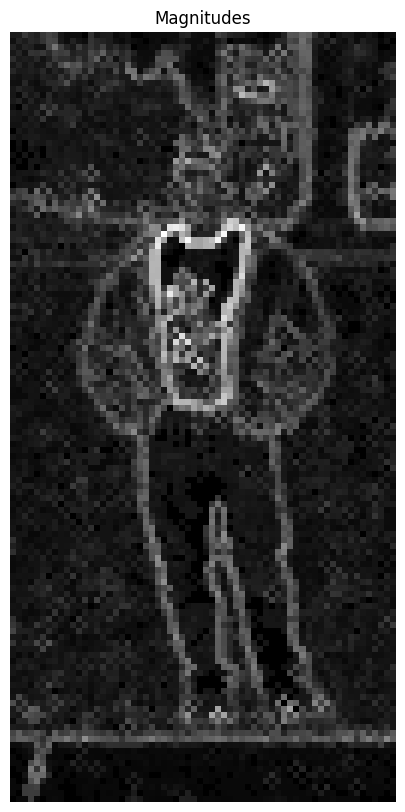

In [11]:
plt.axis('off')
plt.title('Magnitudes')
plt.imshow(gradients, cmap='gray')

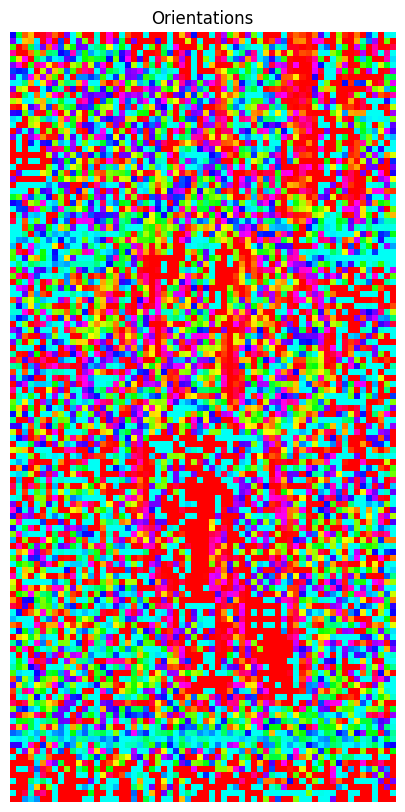

In [12]:
plt.axis('off')
plt.title('Orientations')
plt.imshow(orientations, cmap='hsv')

In [13]:
from math import pow
from typing import List

thresholds: List[int] = [20, 40, 60, 80, 100, 120, 140, 160, 180]

def binary_search(ang: float) -> int:
    low = 0
    high = len(thresholds) - 1
    
    while low <= high:
        mid = (low + high) // 2
        if thresholds[mid] == ang:
            return mid
        elif thresholds[mid] < ang:
            low = mid + 1
        else:
            high = mid - 1
    
    return low


def hog(image: np.ndarray, cell_size: int = 8) -> Tuple[np.ndarray, np.ndarray]:
    y, x, _ = image.shape
    y_cell = np.int32(y / cell_size)
    x_cell = np.int32(x / cell_size)

    magnitude, angle = calculate_gradients_orientation(image)
    histogram: np.ndarray = np.zeros((y_cell, x_cell, 9))
    
    for y_index in range(y_cell):
        for x_index in range(x_cell):
            y_cell_start: int = y_index * cell_size
            y_cell_end: int = (y_index + 1) * cell_size
    
            x_cell_start: int = x_index * cell_size
            x_cell_end: int = (x_index + 1) * cell_size
            
            magnitude_cell: np.ndarray = magnitude[y_cell_start: y_cell_end,
                                                   x_cell_start: x_cell_end]
            angle_cell: np.ndarray = angle[y_cell_start: y_cell_end,
                                           x_cell_start: x_cell_end]
            
            y_inner_length, x_inner_length = magnitude_cell.shape
            
            for y_inner_index in range(y_inner_length):
                for x_inner_index in range(x_inner_length):
                    mag = magnitude_cell[y_inner_index, x_inner_index]
                    ang = angle_cell[y_inner_index, x_inner_index]
                    
                    angle_index = binary_search(ang)
                    threshold = thresholds[angle_index]
                    histogram[y_index, x_index, angle_index] += mag
                    
                    lb: int = threshold - 15
                    ub: int = (threshold - 5)
                    v_ub: float = mag * (ang - lb) / 20
                    v_lb: float = mag * (ub - ang) / 20
                    
                    histogram[y_index, x_index, (angle_index + 1) % 9] += v_ub
                    histogram[y_index, x_index, (angle_index - 1) % 9] += v_lb
    
    e: float = pow(0.00001, 2)
    f: List[np.ndarray] = []
    
    for y_index in range(y_cell - 1):
        for x_index in range(x_cell - 1):
            h0: np.ndarray = histogram[y_index, x_index, :]
            h1: np.ndarray = histogram[y_index, x_index + 1, :]
            h2: np.ndarray = histogram[y_index + 1, x_index, :]
            h3: np.ndarray = histogram[y_index + 1, x_index + 1, :]
            
            h: np.ndarray = np.concatenate((h0, h1, h2, h3))
            n: np.ndarray = np.linalg.norm(h)
            
            h /= np.sqrt(pow(n, 2) + e)
            f = np.concatenate((f, h))
    
    return f, histogram

In [14]:
f, hist = hog(test_image)

In [15]:
f[:10]

array([0.34752823, 0.15800991, 0.09257091, 0.13647062, 0.12451099,
       0.09624949, 0.12017287, 0.16863664, 0.22074944, 0.18455618])

In [16]:
hist

array([[[1109.97020257,  504.6677469 ,  295.66218962, ...,
          383.82005723,  538.60846645,  705.05149589],
        [ 589.45389007,  204.81519586,  792.65045101, ...,
          489.5124079 ,  404.07895881,  842.97441818],
        [ 329.4822507 ,   60.65700329,  377.87678856, ...,
         1002.19587822,  519.45720716,  279.66301987],
        ...,
        [1758.40151455,  485.44632972,  332.51592934, ...,
          228.07041586,  288.47054728, 1579.11799137],
        [2382.69950201,  -19.31531902,  184.61851696, ...,
          119.38898383,  195.16943506, 1500.66521835],
        [ 748.53129973,  -91.98881073,  238.14654764, ...,
          154.9886044 ,  272.78069603,  730.30914512]],

       [[ 533.65994122,  529.09327319,  370.88768417, ...,
          228.90258622,  162.6303965 ,  383.82693709],
        [ 351.65399224,  364.91612402,  514.95496803, ...,
          566.2570289 ,  356.33170311,  338.495984  ],
        [ 437.76476331,  193.40707965,  386.87887663, ...,
          477.

In [17]:
hist.min()

-203.0223437424798

In [18]:
hist.max()

4204.2802613427675

In [19]:
dataset_size: int = 924

HOG_data = np.zeros((dataset_size * 2, len(f) + 1), np.float32)

for index in range(1, dataset_size + 1):
    image_positive = cv2.imread(f'data/pedestrians/pos/per{index:05d}.ppm')
    image_negative = cv2.imread(f'data/pedestrians/neg/neg{index:05d}.png')
    
    F, _ = hog(image_positive)
    HOG_data[index - 1, 0] = 1
    HOG_data[index - 1, 1:] = F
    
    F, _ = hog(image_negative)
    HOG_data[index + dataset_size - 1, 0] = 0
    HOG_data[index + dataset_size - 1, 1:] = F

In [20]:
from sklearn.model_selection import train_test_split

labels: np.ndarray = HOG_data[:, 0]
data: np.ndarray = HOG_data[:, 1:]

x_train, x_test, y_train, y_test = train_test_split(HOG_data[:, 1:], HOG_data[:, 0], test_size=0.5)

In [21]:
from sklearn.svm import SVC

clf = SVC(kernel='poly', degree=4)
clf.fit(x_train, y_train)

SVC(degree=4, kernel='poly')

In [22]:
lp = clf.predict(x_train)
print(f"Accuracy: {np.sum(lp == y_train) / dataset_size * 100}%")

Accuracy: 100.0%


In [23]:
from sklearn.metrics import confusion_matrix, f1_score

confusion_matrix(y_train, lp)

array([[465,   0],
       [  0, 459]], dtype=int64)

In [24]:
f1_score(y_train, lp)

1.0

In [25]:
lp = clf.predict(x_test)
print(f"Accuracy: {np.sum(lp == y_test) / dataset_size * 100}%")

Accuracy: 99.89177489177489%


In [46]:
confusion_matrix(y_test, lp)

array([[459,   0],
       [  1, 464]], dtype=int64)

In [27]:
f1_score(y_test, lp)

0.9989235737351991

In [47]:
t1 = cv2.imread('data/test_pedestrians/testImage1.png')
t1 = cv2.resize(t1, (int(t1.shape[1] * 0.5), int(t1.shape[0] * 0.5)))
t2 = cv2.imread('data/test_pedestrians/testImage2.png')
t2 = cv2.resize(t2, (int(t2.shape[1] * 0.5), int(t2.shape[0] * 0.5)))
t3 = cv2.imread('data/test_pedestrians/testImage3.png')
t3 = cv2.resize(t3, (int(t3.shape[1] * 0.5), int(t3.shape[0] * 0.5)))
t4 = cv2.imread('data/test_pedestrians/testImage4.png')
t4 = cv2.resize(t4, (int(t4.shape[1] * 0.4), int(t4.shape[0] * 0.4)))

In [50]:
from copy import deepcopy

def detect_pedestrians(image: np.ndarray) -> np.ndarray:
    win_width, win_height = 64, 128
    image_copy = deepcopy(image)

    max_score: float = float('inf')
    maximum_rectangle: Tuple[int, int] = (0, 0) 

    for y in range(0, image.shape[0], 8):
        for x in range(0, image.shape[1], 8):
            window: np.ndarray = image[y: y + win_height,
                                       x: x + win_width]
            
            if window.shape[0] != win_height or window.shape[1] != win_width:
                continue
                
            f_curr, _ = hog(window)
            f_curr = f_curr.reshape(1, -1)
            
            if clf.predict(f_curr) == 1 and max_score > abs(clf.decision_function(f_curr)):
                maximum_rectangle = (x, y)
                
    x, y = maximum_rectangle
    if max_score > 0.:
        cv2.rectangle(image_copy, (x, y), (x + win_width, y + win_height), (255, 255, 0), 2)
    
    return image_copy

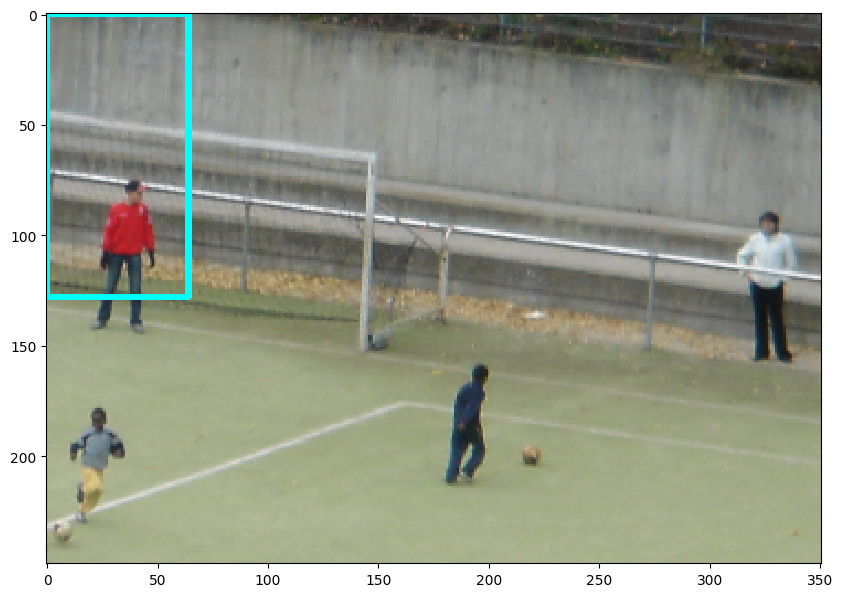

In [36]:
plt.imshow(cv2.cvtColor(detect_pedestrians(t1), cv2.COLOR_BGR2RGB))

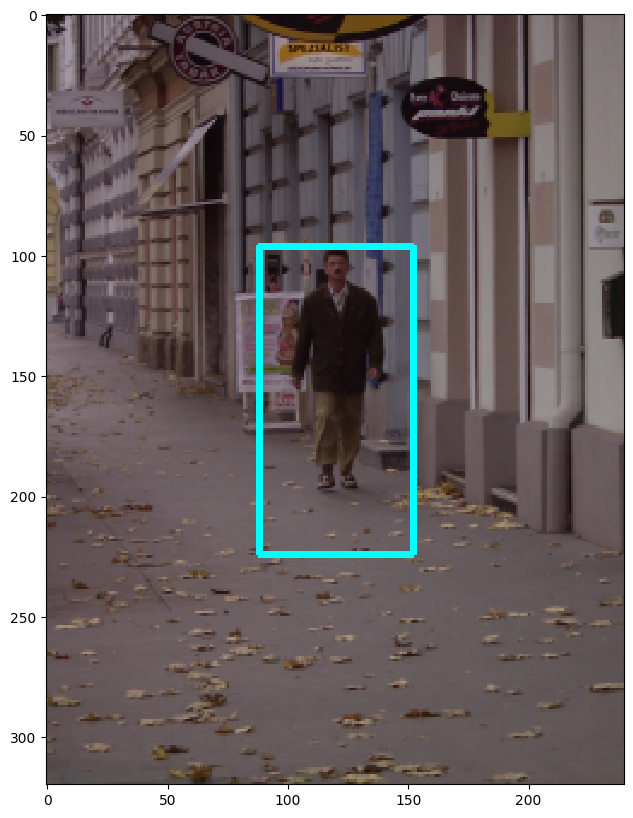

In [51]:
plt.imshow(cv2.cvtColor(detect_pedestrians(t2), cv2.COLOR_BGR2RGB))

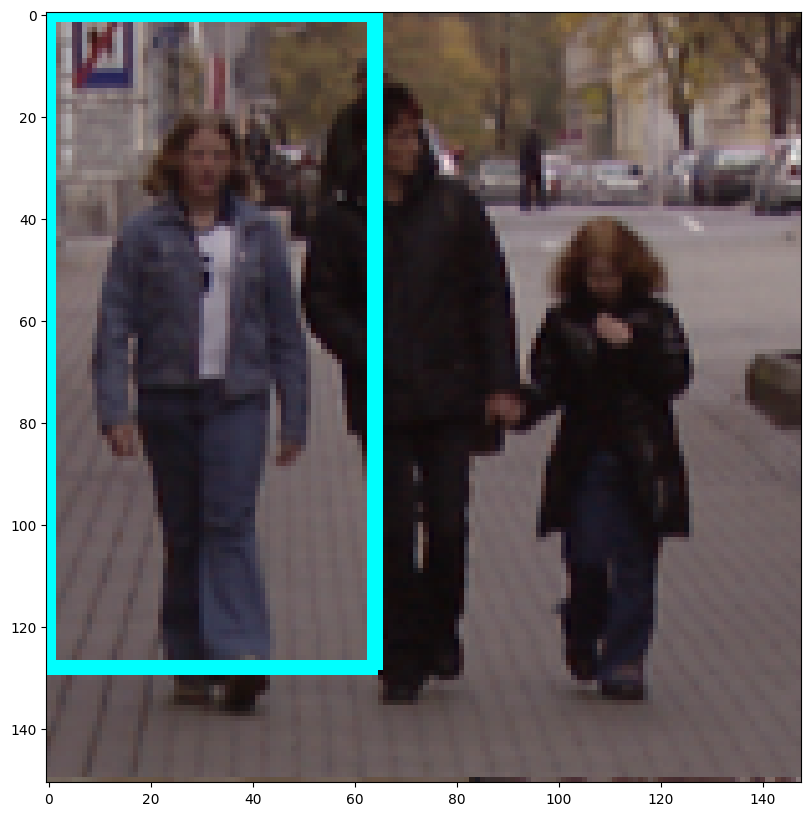

In [38]:
plt.imshow(cv2.cvtColor(detect_pedestrians(t3), cv2.COLOR_BGR2RGB))

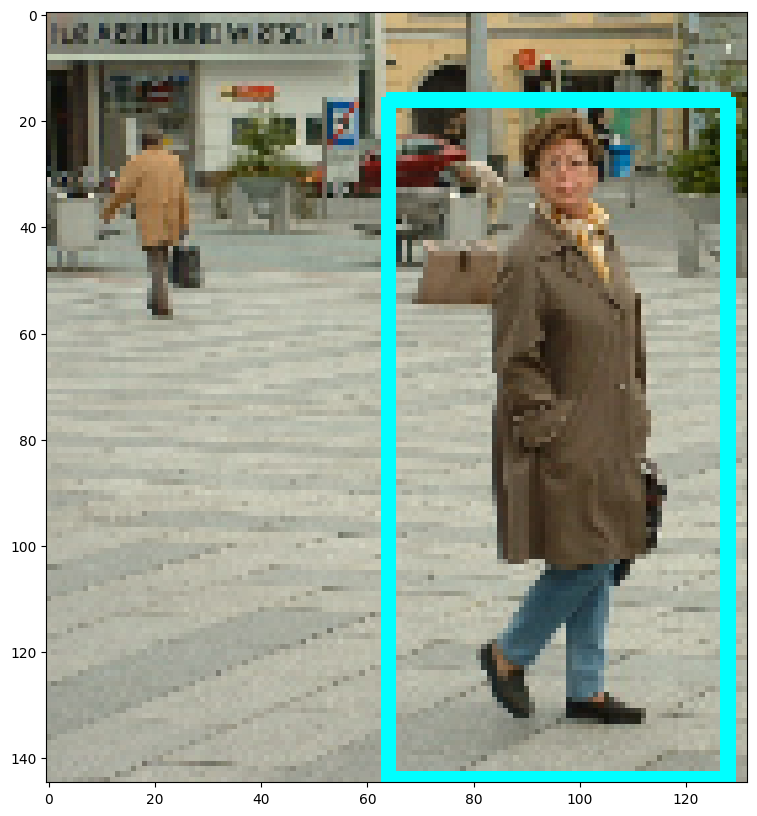

In [39]:
plt.imshow(cv2.cvtColor(detect_pedestrians(t4), cv2.COLOR_BGR2RGB))